In [1]:
import pandas as pd
import zipfile
import os
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad
import seaborn as sns
from scipy import stats
pd.set_option('display.max_rows', 250)

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [2]:
file_name = "../../metadata/rna_tissue_consensus.tsv.zip"
df = pd.read_csv(file_name, sep='\t', compression='zip')
adata_final = sc.read_h5ad('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering.h5ad', backed='r')
de_summary_stats = pd.read_csv('../../../../3_expts/processed_data/CD4i_final/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)
df['log1p_nTPM'] = np.log1p(df['nTPM'])
df = df[df['Gene'].isin(adata_final.obs.target_contrast_corrected.unique().tolist())].copy()

### First calculate the expression specificity index (tau) and tissue expression enrichment for selective genes

In [3]:
# Tissue expression enrichment fold change threshold
LFC_THRESHOLD = 2
# Threshold for large tau
TAU_THRESHOLD = 0.5

In [4]:
def calculate_tau(row):
    """
    Calculates Tau specificity index.
    Formula: Sum(1 - (xi / max_x)) / (N - 1)
    """
    if row.max() == 0:
        return 0.0
    
    x_hat = row / row.max()
    tau = (1 - x_hat).sum() / (len(row) - 1)
    return tau

def analyze_gene_set(gene_set_name, gene_names_list, final_df, tau_threshold=0.5):
    """
    Calculates the fraction of genes above a Tau threshold and the fraction
    enriched in each tissue for a given gene set.
    """
    # Filter the final_df for the genes in the set using the 'Gene name' level of the MultiIndex
    set_data = final_df[final_df.index.get_level_values('Gene').isin(gene_names_list)]

    N = len(set_data)
    
    # 1. Fraction of genes with Tau_Index > threshold
    tau_frac = (set_data['Tau_Index'] > tau_threshold).sum() / N
    
    result_dict = {'large_tau_fraction': tau_frac}

    # 2. Fraction of genes enriched in each tissue
    # Select columns ending with ' (Enriched)'
    enrichment_cols = [col for col in set_data.columns if col.endswith(' (Enriched)')]
    
    for col in enrichment_cols:
        # .sum() works on boolean columns (True=1, False=0). Divide by N to get fraction.
        enrichment_frac = set_data[col].sum() / N
        
        # Clean up column name for final output (e.g., 'adipose tissue (Enriched)' -> 'adipose tissue_Enrich_Fraction')
        clean_col = col.replace(' (Enriched)', '')
        result_dict[clean_col] = enrichment_frac
        
    return pd.Series(result_dict, name=gene_set_name)

In [5]:
# Pivot to get Genes x Tissues matrix using log1p_nTPM
tau_pivot = df.pivot_table(
    index=['Gene', 'Gene name'], 
    columns='Tissue', 
    values='log1p_nTPM', 
    fill_value=0
)

# Apply Tau calculation row-wise
tau_series = tau_pivot.apply(calculate_tau, axis=1)
tau_series.name = 'Tau_Index'

# Calculate Log2 Fold Change
mean_ntpm = df.groupby(['Gene', 'Gene name'])['nTPM'].transform('mean')
df['LFC'] = np.log2((df['nTPM'] + 1e-6) / (mean_ntpm + 1e-6))
df['Enriched'] = df['LFC'] > LFC_THRESHOLD
# Pivot
lfc_pivot = df.pivot_table(
    index=['Gene', 'Gene name'], 
    columns='Tissue', 
    values='LFC'
).add_suffix(' (LFC)')

enrich_pivot = df.pivot_table(
    index=['Gene', 'Gene name'], 
    columns='Tissue', 
    values='Enriched'
).add_suffix(' (Enriched)')
lfc_pivot = lfc_pivot.fillna(0)
enrich_pivot = enrich_pivot.fillna(False).astype(bool)
final_df = pd.concat([tau_series, lfc_pivot, enrich_pivot], axis=1)
final_df = final_df.reindex(sorted(final_df.columns), axis=1)

cols = ['Tau_Index'] + [c for c in final_df.columns if c != 'Tau_Index']
final_df = final_df[cols]

In [6]:
# Check fraction of genes that have large tau, and have tissue expression enrichment in each tissue
num_clusters = 111
gene_sets = {}
for cl in range(num_clusters):
    gene_ids = adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_corrected.unique().tolist()
    gene_sets[cl] = gene_ids

results = []

for set_id, gene_list in gene_sets.items():
    set_result = analyze_gene_set(set_id, gene_list, final_df, tau_threshold=TAU_THRESHOLD)
    results.append(set_result)

gene_set_analysis_df = pd.DataFrame(results)
gene_set_analysis_df = gene_set_analysis_df.reset_index().rename(columns={'index': 'cluster'})

### Get annotated and unannotated clusters

In [30]:
final_df[final_df.index.get_level_values('Gene name') == 'ICOS']

,,Tau_Index,adipose tissue (Enriched),adipose tissue (LFC),adrenal gland (Enriched),adrenal gland (LFC),amygdala (Enriched),amygdala (LFC),appendix (Enriched),appendix (LFC),basal ganglia (Enriched),...,thyroid gland (Enriched),thyroid gland (LFC),tongue (Enriched),tongue (LFC),tonsil (Enriched),tonsil (LFC),urinary bladder (Enriched),urinary bladder (LFC),vagina (Enriched),vagina (LFC)
Gene,Gene name,,,,,,,,,,,,,,,,,,,,,
ENSG00000163600,ICOS,0.843211,False,-2.152531,False,-4.15252,False,-20.762175,True,2.017391,False,...,False,-2.152531,False,-20.762175,True,3.095393,False,0.491323,False,-3.152527


In [31]:
gene_set_analysis_df

,cluster,large_tau_fraction,adipose tissue,adrenal gland,amygdala,appendix,basal ganglia,blood vessel,bone marrow,breast,...,spinal cord,spleen,stomach,testis,thymus,thyroid gland,tongue,tonsil,urinary bladder,vagina
0,0,0.285714,0.142857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2,2,0.090909,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.0
4,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
5,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
6,6,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.000000,...,0.000000,0.000000,0.000000,0.166667,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
7,7,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.1
8,8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
9,9,0.176471,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.029412,0.000000,0.088235,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


In [484]:
def calculate_tau(matrix: pd.DataFrame) -> pd.Series:
    """Calculates the Tau specificity index for each gene (row)."""
    
    # Max Normalization: x_i / max(x)
    # Get the maximum expression across all tissues for each gene (row)
    max_vals = matrix.max(axis=1)
    
    # Handle the case where max_vals is 0 (i.e., gene is not expressed anywhere)
    max_vals[max_vals == 0] = 1e-9 
    
    # Normalized expression (x_hat)
    normalized = matrix.div(max_vals, axis=0)
    
    # Sum of (1 - x_hat)
    sum_term = (1 - normalized).sum(axis=1)
    
    # Divide by (N_tissues - 1)
    n_tissues = matrix.shape[1]
    tau_scores = sum_term / (n_tissues - 1)
    
    return tau_scores

In [490]:
# Get gene id for all regulator genes
gene_id_in_clustering = adata_final.obs.target_contrast_corrected.unique().tolist()
#gene_id_in_clustering = adata_final[adata_final.obs.hdbscan==27].obs.target_contrast_corrected.unique().tolist()
# Set tau threshold to 0.8
tau_thres = 0.8

# Pivot the data to create the Expression Matrix (Genes x Tissues)
# Use the Ensembl ID (Gene) as the index for robustness
expression_matrix = df.pivot_table(
    index='Gene', 
    columns='Tissue', 
    values='log1p_nTPM'
)
expression_matrix.fillna(0)

# Filter the matrix to include only your genes
subset_matrix = expression_matrix.reindex(gene_id_in_clustering)

# Calculate the Tau scores
tau_scores = calculate_tau(subset_matrix)

# Determine the tissue with the highest expression for each gene
max_tissue = subset_matrix.idxmax(axis=1)

# List of immune/lymphoid tissues for classification (based on previous discussion)
IMMUNE_TISSUES = [
    'thymus', 'lymph node', 'spleen', 'bone marrow', 'tonsil', 'appendix', 
]

# Create the final results DataFrame
results = pd.DataFrame({
    'Tau_Score': tau_scores,
    'Max_Expression_Tissue': max_tissue,
    'Is_Tissue_Specific': tau_scores >= tau_thres,
})

# Classify as Immune-Specific
results['Is_Immune_Specific'] = results.apply(
    lambda row: row['Is_Tissue_Specific'] and (row['Max_Expression_Tissue'] in IMMUNE_TISSUES), 
    axis=1
)

gene_name_map = adata_final.obs[['target_contrast_corrected', 'target_contrast_gene_name_corrected']].drop_duplicates().set_index('target_contrast_corrected')
results = results.join(gene_name_map)

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_9081/2635594124.py:23: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  max_tissue = subset_matrix.idxmax(axis=1)


In [661]:
genelist = list(set(adata_final[adata_final.obs.hdbscan==76].obs.target_contrast_gene_name_corrected.unique())&set(results.target_contrast_gene_name_corrected))

In [662]:
np.sum(results[results['target_contrast_gene_name_corrected'].isin(genelist)].Tau_Score>0.5)/len(genelist)

0.14102564102564102

In [660]:
results[results['target_contrast_gene_name_corrected'].isin(genelist)]

,Tau_Score,Max_Expression_Tissue,Is_Tissue_Specific,Is_Immune_Specific,target_contrast_gene_name_corrected
Gene,,,,,
ENSG00000033011,0.358340,choroid plexus,False,False,ALG1
ENSG00000169020,0.201656,heart muscle,False,False,ATP5ME
ENSG00000109270,0.158891,epididymis,False,False,LAMTOR3
ENSG00000155876,0.143488,skeletal muscle,False,False,RRAGA
ENSG00000241468,0.180477,tongue,False,False,ATP5MF
ENSG00000152684,0.305418,adrenal gland,False,False,PELO
ENSG00000164654,0.430716,skeletal muscle,False,False,MIOS
ENSG00000173812,0.221095,skeletal muscle,False,False,EIF1
ENSG00000168769,0.482765,bone marrow,False,False,TET2


In [567]:
adata_final[adata_final.obs.target_contrast_gene_name_corrected=='TBX21'].obs

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected,hdbscan
ENSG00000073861_Stim8hr,TBX21,Stim8hr,ENSG00000073861,209,415.0,ENSG00000073861,TBX21,80
ENSG00000073861_Stim48hr,TBX21,Stim48hr,ENSG00000073861,578,382.0,ENSG00000073861,TBX21,99


In [641]:
cl_list = [0, 2, 7, 9, 10, 15, 28, 31, 32, 33, 36, 37, 41, 47, 48, 58, 65, 66, 68, 76, 87, 103, 108, 111,
           21, 22, 25, 26, 27, 35, 42, 44, 54, 57, 60, 61, 74, 77, 78, 84, 99, 101, 102, 105, 106, 107, 109]

In [652]:
tau_data_for_plot = []
for cl in cl_list:
    genelist = list(set(adata_final[adata_final.obs.hdbscan==cl].obs.target_contrast_gene_name_corrected.unique())&set(results.target_contrast_gene_name_corrected))
    tau = results[results['target_contrast_gene_name_corrected'].isin(genelist)].Tau_Score
    temp_df = pd.DataFrame({
        'Tau_Score': tau.values,
        'Cluster_ID': cl,
        'Large_tau_fraction': np.sum(tau>0.5)/len(genelist)
        })
    tau_data_for_plot.append(temp_df)
final_plot_df = pd.concat(tau_data_for_plot, ignore_index=True)

In [653]:
final_plot_df

,Tau_Score,Cluster_ID,Large_tau_fraction
0,0.736270,0,0.285714
1,0.305871,0,0.285714
2,0.164473,0,0.285714
3,0.209011,0,0.285714
4,0.135762,0,0.285714
...,...,...,...
1794,0.874459,109,0.333333
1795,0.507814,109,0.333333
1796,0.171313,109,0.333333
1797,0.320249,109,0.333333


<Axes: xlabel='Cluster_ID', ylabel='Large_tau_fraction'>

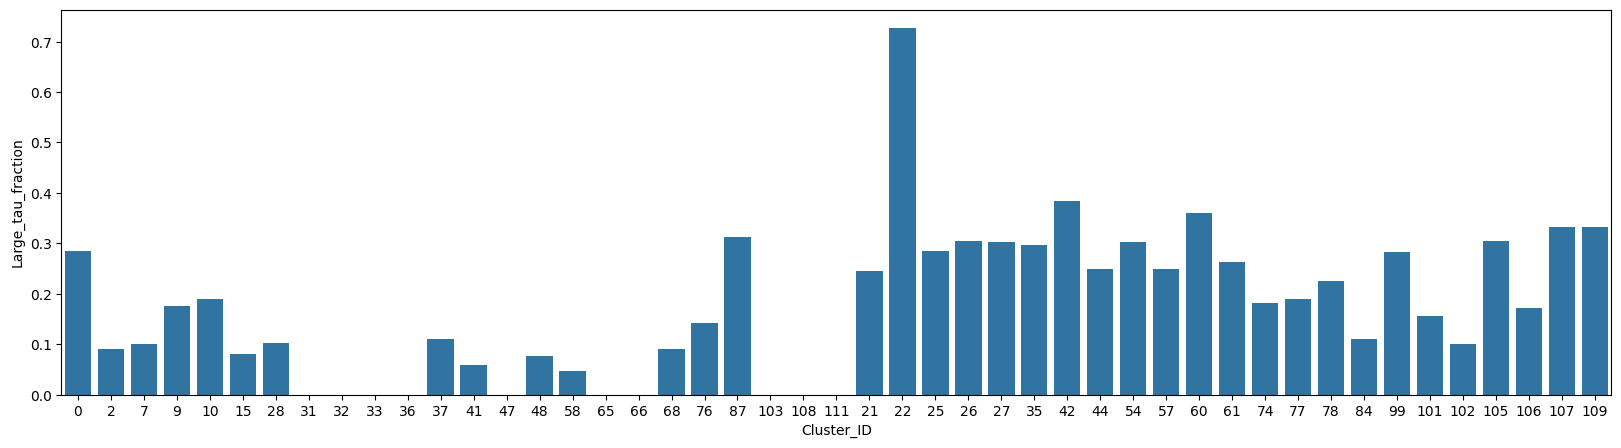

In [654]:
fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(
    data=final_plot_df,
    x='Cluster_ID',
    y='Large_tau_fraction',
    order=cl_list,
    ax=ax
)

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 9.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 48.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 20.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/rzhu/miniconda3/en

<Axes: xlabel='Cluster_ID', ylabel='Tau_Score'>

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 45.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 18.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 23.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/rzhu/miniconda3/e

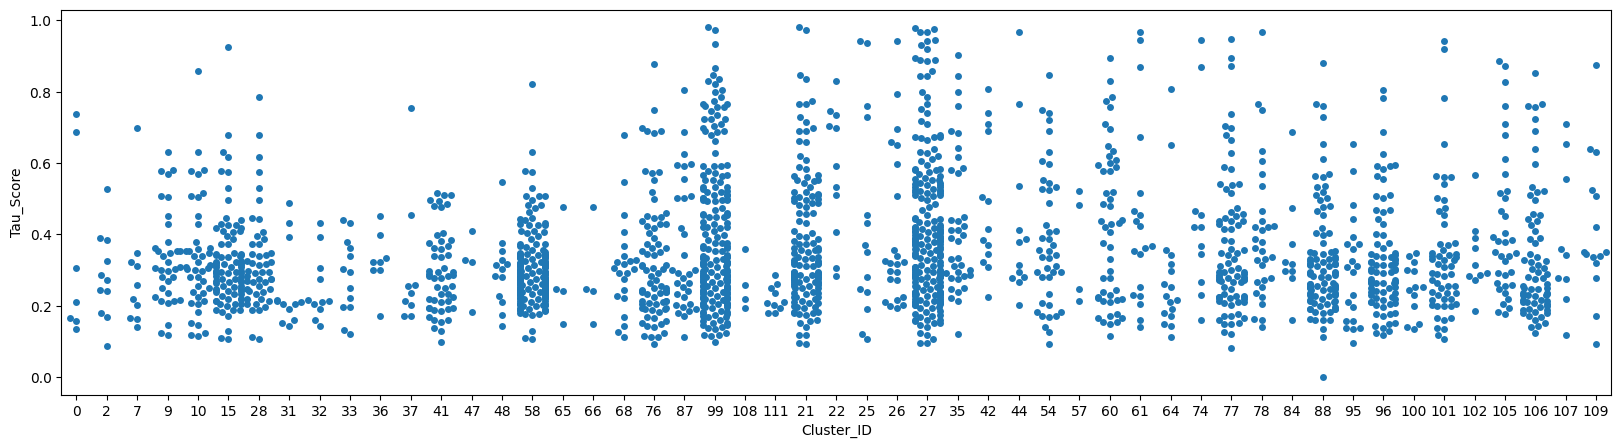

In [625]:
fig, ax = plt.subplots(figsize=(20,5))
sns.swarmplot(
    data=final_plot_df,
    x='Cluster_ID',
    y='Tau_Score',
    order=cl_list,
    ax=ax
)

In [577]:
results[results['target_contrast_gene_name_corrected'].isin(genelist)]

,Tau_Score,Max_Expression_Tissue,Is_Tissue_Specific,Is_Immune_Specific,target_contrast_gene_name_corrected
Gene,,,,,
ENSG00000108349,0.140695,blood vessel,False,False,CASC3
ENSG00000116698,0.258895,testis,False,False,SMG7
ENSG00000105771,0.347455,testis,False,False,SMG9
ENSG00000167720,0.219466,retina,False,False,SRR
ENSG00000114127,0.312016,bone marrow,False,False,XRN1
ENSG00000151461,0.164358,skeletal muscle,False,False,UPF2
ENSG00000157106,0.321937,skeletal muscle,False,False,SMG1
ENSG00000167447,0.203346,ovary,False,False,SMG8
ENSG00000163472,0.697370,esophagus,False,False,TMEM79


In [5]:
file_name = "../../../../3_expts/processed_data/analysis_largefiles/rna_single_cell_cluster.tsv.zip"
df = pd.read_csv(file_name, sep='\t', compression='zip')
file_name = "../../../../3_expts/processed_data/analysis_largefiles/rna_single_cell_clusters.tsv.zip"
df_metadata = pd.read_csv(file_name, sep='\t', compression='zip')

In [51]:
df['Tissue_Cap'] = df['Tissue'].str.capitalize()
df['Cell_type_Cap'] = df['Cell type'].apply(lambda x: ' '.join([w.capitalize() for w in x.split()]))

# Create a unique sample identifier for the columns (.obs)
# We assume a unique sample (observation) is defined by the combination of the three factors
df['Sample_ID'] = df['Tissue_Cap'] + '_' + df['Cluster'] + '_' + df['Cell_type_Cap']

# Pivot the data into wide matrices
# Fill NaN with 0.0 (since missing Gene/Sample combinations mean 0 expression/count)
X_matrix = df.pivot_table(
    index='Gene',         # Rows in the matrix (Genes -> .var)
    columns='Sample_ID',  # Columns in the matrix (Samples -> .obs)
    values='nCPM',        # Values for the expression matrix (.X)
    fill_value=0.0
).T # Transpose to get (Samples x Genes), which is the standard AnnData shape

Count_matrix = df.pivot_table(
    index='Gene',
    columns='Sample_ID',
    values='Read count',
    fill_value=0.0
).T # Transpose to get (Samples x Genes)

# Initialize AnnData with the expression matrix (.X)
adata = ad.AnnData(
    X=X_matrix.values,
    obs=pd.DataFrame(index=X_matrix.index), # Start with an empty .obs, indexed by Sample_ID
    var=pd.DataFrame(index=X_matrix.columns) # Start with an empty .var, indexed by Gene
)

# Add Read count data to a layer
adata.layers['counts'] = Count_matrix.values

# Create a mapping from Gene ID to Gene name
gene_map = df[['Gene', 'Gene name']].drop_duplicates().set_index('Gene')

# Add the 'Gene name' column to .var, matching the index
adata.var['Gene name'] = adata.var.index.map(gene_map['Gene name'])

# Extract original df metadata components from the Sample_ID index
obs_df = adata.obs.index.to_series().str.split('_', expand=True)
obs_df.columns = ['Tissue', 'Cluster', 'Cell type']
obs_df['Tissue_Cluster'] = obs_df['Tissue'] + '_' + obs_df['Cluster']

# Merge with df_metadata using the 'Tissue_Cluster' key
# The AnnData .obs index (Sample_ID) must be maintained
df_metadata['Tissue_Cluster'] = df_metadata['Tissue'] + '_' + df_metadata['Cluster']
obs_df = obs_df.reset_index().merge(df_metadata.drop(columns=['Tissue', 'Cluster', 'Cell type']),
                                    on='Tissue_Cluster',
                                    how='left').set_index('Sample_ID')
obs_df.drop(columns=['Tissue_Cluster'], inplace=True)
adata.obs = obs_df

adata.write_h5ad('../../../../3_expts/processed_data/analysis_largefiles/rna_single_cell_HPA.h5ad')

In [88]:
adata = sc.read_h5ad('../../../../3_expts/processed_data/analysis_largefiles/rna_single_cell_HPA.h5ad', backed='r')
obs_mask = (adata.obs['Cell count']>100)&(adata.obs['Annotation reliability']=='High')&(adata.obs['Included in aggregation']=='Yes')
var_mask = adata.var_names.isin(adata_final.obs.target_contrast_corrected)
adata = adata[:,var_mask].to_memory().copy()
adata = adata[obs_mask].copy()

In [109]:
df_wide = adata.to_df().reset_index(names='Observation ID')
df_obs = adata.obs.reset_index(names='Observation ID')
df_var = adata.var.reset_index(names='Gene_ID')
df_long = df_wide.melt(
    id_vars=['Observation ID'],
    var_name='Gene_ID',
    value_name='Expression'
)
df_merged_obs = pd.merge(
    df_long,
    df_obs,
    on='Observation ID',
    how='left'
)
df_final_long = pd.merge(
    df_merged_obs,
    df_var,
    on='Gene_ID',
    how='left'
)
df_final_long['Gene name'] = df_final_long['Gene name'].astype(str)

In [360]:
def calculate_expression_fraction(df, cutoff=10):
    """
    Calculates the fraction of samples where Expression > Cutoff
    for each Gene and Cell type class.
    
    Args:
        df (pd.DataFrame): Dataframe containing 'Gene_ID', 'Cell type class', and 'Expression'.
        cutoff (float): The expression threshold to consider a gene 'ON'.
        
    Returns:
        pd.DataFrame: A pivot table with Genes as rows, Cell classes as columns,
                      and values representing the fraction (0.0 to 1.0).
    """
    
    # 1. Create a boolean mask: Is the expression above the cutoff?
    # We create a new temporary column for this logic
    df['is_above_cutoff'] = df['Expression'] > cutoff

    # 2. Group by Gene and Cell Class
    # Taking the 'mean' of a boolean series (True/False) calculates the fraction of True values.
    # True = 1, False = 0. So (1+1+0+0)/4 = 0.5 (50%)
    fraction_data = df.groupby(['Gene name', 'Cell type class'])['is_above_cutoff'].mean().reset_index()

    # 3. Rename columns for clarity
    fraction_data.rename(columns={'is_above_cutoff': 'fraction_expressed'}, inplace=True)

    # 4. Pivot the table for easier reading/heatmapping
    # Rows = Genes, Columns = Cell Types, Values = Fraction
    # fill_value=0 ensures that missing combinations (gene never seen in that cell type) are 0
    pivot_df = fraction_data.pivot(index='Gene name', 
                                   columns='Cell type class', 
                                   values='fraction_expressed').fillna(0)
    
    return pivot_df

In [337]:
def calculate_gene_set_mean(fraction_df, gene_set):
    """
    Calculates the average fraction of expression for a specific set of genes
    across all cell type classes.
    
    Args:
        fraction_df (pd.DataFrame): The output of calculate_expression_fraction (index=Genes).
        gene_set (list): A list of Gene_IDs to aggregate.
        
    Returns:
        pd.Series: Mean fraction for each cell type class across the gene set.
    """
    # Filter for genes that exist in our matrix
    valid_genes = [g for g in gene_set if g in fraction_df.index]
    
    if not valid_genes:
        print("Warning: No genes from the set were found in the dataframe.")
        return pd.Series(dtype=float)
        
    # Subset the matrix
    subset = fraction_df.loc[valid_genes]
    
    # Calculate column means (aggregating across the gene set)
    # This gives one value per cell type class representing how "active" this gene set is
    mean_fractions = subset.mean(axis=0)
    
    return mean_fractions

In [413]:
genelist = list(set(adata_final[adata_final.obs.hdbscan==2].obs.target_contrast_gene_name_corrected.unique())&set(result_matrix.index))

In [414]:
np.sum((result_matrix.loc[genelist]>0.25).sum(1)<=7)/len(genelist)

0.5454545454545454

In [415]:
result_matrix.loc[genelist]

Cell type class,Blood and immune cells,Ciliated cells,Endocrine cells,Endothelial and mural cells,Germ cells,Glandular epithelial cells,Glial cells,Mesenchymal cells,Muscle cells,Neuronal cells,Pigment cells,Specialized epithelial cells,Squamous epithelial cells,Stem and proliferating cells,Trophoblast cells
Gene name,,,,,,,,,,,,,,,
RO60,0.988462,1.0,1.000000,1.000000,1.000000,0.973684,1.000000,1.000000,1.00,1.000000,1.0,1.000000,1.0,1.000000,1.000000
ACTR8,0.088462,0.0,0.000000,0.000000,0.722222,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.090909
UCHL5,0.915385,0.5,0.736842,0.853211,0.222222,0.763158,0.909091,0.782051,1.00,0.953488,1.0,0.933333,1.0,0.857143,1.000000
INO80B,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000
INO80E,0.338462,0.4,0.368421,0.678899,0.388889,0.710526,0.363636,0.410256,0.08,0.034884,0.0,0.573333,0.5,0.857143,0.818182
INO80C,0.000000,0.0,0.000000,0.000000,0.388889,0.013158,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.2,0.000000,0.000000
ACTR5,0.007692,0.0,0.052632,0.000000,0.166667,0.000000,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000
HEY1,0.042308,0.1,0.000000,0.339450,0.055556,0.131579,0.227273,0.012821,0.00,0.058140,1.0,0.053333,0.0,0.285714,0.272727
INO80,0.980769,1.0,1.000000,1.000000,0.388889,1.000000,0.954545,1.000000,1.00,1.000000,1.0,1.000000,1.0,1.000000,1.000000


In [425]:
df

,Gene,Gene name,Tissue,nTPM
0,ENSG00000000003,TSPAN6,adipose tissue,20.1
1,ENSG00000000003,TSPAN6,adrenal gland,13.3
2,ENSG00000000003,TSPAN6,amygdala,8.7
3,ENSG00000000003,TSPAN6,appendix,4.6
4,ENSG00000000003,TSPAN6,basal ganglia,8.4
...,...,...,...,...
1026287,ENSG00000291317,TMEM276,thymus,5.8
1026288,ENSG00000291317,TMEM276,thyroid gland,10.9
1026289,ENSG00000291317,TMEM276,tongue,6.1
1026290,ENSG00000291317,TMEM276,tonsil,4.6


In [431]:
new_df = df.pivot(index='Gene', columns='Tissue', values='nTPM')
new_df.fillna(0)
new_df = new_df[new_df.index.isin(adata_final.obs.target_contrast_corrected.unique())]

In [470]:
genelist = list(set(adata_final[adata_final.obs.hdbscan==58].obs.target_contrast_corrected.unique())&set(new_df.index))

In [471]:
np.sum((new_df.loc[genelist]>5).sum(1)<=25)/len(genelist)

0.14367816091954022

In [467]:
new_df.loc[genelist]

Tissue,adipose tissue,adrenal gland,amygdala,appendix,basal ganglia,blood vessel,bone marrow,breast,cerebellum,cerebral cortex,...,spinal cord,spleen,stomach,testis,thymus,thyroid gland,tongue,tonsil,urinary bladder,vagina
Gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000168484,2.4,21.9,7.1,9.8,11.9,4.1,0.0,0.8,3.4,7.6,...,16.2,13.2,6.1,2.7,0.0,3.9,0.1,0.2,0.3,0.8
ENSG00000157450,7.7,7.1,3.2,11.2,3.9,6.9,16.2,7.3,7.6,9.2,...,4.3,10.4,8.5,8.8,10.7,10.8,11.0,12.5,9.6,6.7
ENSG00000136156,478.9,347.0,317.3,162.8,323.7,301.2,118.6,303.8,409.9,321.2,...,449.5,410.2,294.9,113.5,175.6,362.1,192.4,175.9,285.5,295.9
ENSG00000143157,10.6,8.6,21.3,12.7,20.5,14.2,10.3,13.3,15.7,17.1,...,30.1,13.4,13.2,5.9,11.5,10.9,8.8,15.8,16.4,11.0
ENSG00000070770,20.8,14.6,14.2,8.5,16.6,30.1,6.0,18.9,10.7,16.3,...,11.9,13.0,28.4,113.9,17.0,17.6,24.9,16.2,26.6,19.2
ENSG00000165118,7.5,8.5,3.9,7.9,4.5,5.0,2.2,7.4,2.8,3.9,...,4.1,6.2,9.1,7.7,9.3,15.0,6.6,7.6,7.2,4.6
ENSG00000109956,0.2,4.0,150.4,0.3,89.8,0.3,0.8,3.6,35.5,148.7,...,191.4,1.3,33.1,0.9,0.4,5.8,0.2,0.3,0.6,0.3
ENSG00000141985,58.1,62.7,29.3,27.7,24.3,48.7,51.1,48.3,36.6,41.3,...,24.0,45.0,34.6,27.1,15.7,35.6,9.4,18.6,46.5,87.7
ENSG00000087460,699.7,1121.4,1841.6,456.4,804.1,972.8,773.6,623.1,1371.2,2064.1,...,1200.1,535.4,573.1,309.3,722.7,2932.2,2362.1,683.0,582.2,684.6


In [416]:
df_final_long[df_final_long['Gene name']=='INO80B']

,Observation ID,Gene_ID,Expression,Tissue,Cluster,Cell type,Cell type detail,Cell type group,Cell type class,Cell count,Included in aggregation,Annotation reliability,Gene name,is_above_cutoff
416120,Adipose tissue_c-0_Mesothelial Cells,ENSG00000115274,0.1,Adipose tissue,c-0,Mesothelial Cells,Mesothelial cells,Cell type group,Specialized epithelial cells,8942,Yes,High,INO80B,False
416121,Adipose tissue_c-10_Vascular Endothelial Cells,ENSG00000115274,0.0,Adipose tissue,c-10,Vascular Endothelial Cells,Venous endothelial cells,Cell type group,Endothelial and mural cells,965,Yes,High,INO80B,False
416122,Adipose tissue_c-11_Vascular Endothelial Cells,ENSG00000115274,0.0,Adipose tissue,c-11,Vascular Endothelial Cells,Capillary endothelial cells,Cell type group,Endothelial and mural cells,920,Yes,High,INO80B,False
416123,Adipose tissue_c-13_Vascular Endothelial Cells,ENSG00000115274,0.0,Adipose tissue,c-13,Vascular Endothelial Cells,Arterial endothelial cells,Cell type group,Endothelial and mural cells,843,Yes,High,INO80B,False
416124,Adipose tissue_c-14_Lymphatic Endothelial Cells,ENSG00000115274,0.0,Adipose tissue,c-14,Lymphatic Endothelial Cells,Lymphatic endothelial cells,Cell type group,Endothelial and mural cells,825,Yes,High,INO80B,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416923,Vasculature_c-5_Vascular Smooth Muscle Cells,ENSG00000115274,0.4,Vasculature,c-5,Vascular Smooth Muscle Cells,Vascular smooth muscle cells (PDGFRA+),Cell type group,Endothelial and mural cells,1590,Yes,High,INO80B,False
416924,Vasculature_c-6_Macrophages,ENSG00000115274,0.5,Vasculature,c-6,Macrophages,Macrophages,Cell type group,Blood and immune cells,1442,Yes,High,INO80B,False
416925,Vasculature_c-7_Vascular Smooth Muscle Cells,ENSG00000115274,0.3,Vasculature,c-7,Vascular Smooth Muscle Cells,Vascular smooth muscle cells,Cell type group,Endothelial and mural cells,1166,Yes,High,INO80B,False
416926,Vasculature_c-8_Neutrophils,ENSG00000115274,0.7,Vasculature,c-8,Neutrophils,Neutrophils,Cell type group,Blood and immune cells,864,Yes,High,INO80B,False


In [388]:
result_matrix.loc['ICOS']

Cell type class
Blood and immune cells          0.380769
Ciliated cells                  0.000000
Endocrine cells                 0.000000
Endothelial and mural cells     0.000000
Germ cells                      0.000000
Glandular epithelial cells      0.000000
Glial cells                     0.000000
Mesenchymal cells               0.000000
Muscle cells                    0.000000
Neuronal cells                  0.000000
Pigment cells                   0.000000
Specialized epithelial cells    0.000000
Squamous epithelial cells       0.000000
Stem and proliferating cells    0.000000
Trophoblast cells               0.000000
Name: ICOS, dtype: float64

In [387]:
result_matrix.loc['ACTB']

Cell type class
Blood and immune cells          1.000000
Ciliated cells                  1.000000
Endocrine cells                 1.000000
Endothelial and mural cells     1.000000
Germ cells                      1.000000
Glandular epithelial cells      1.000000
Glial cells                     1.000000
Mesenchymal cells               0.974359
Muscle cells                    1.000000
Neuronal cells                  0.988372
Pigment cells                   1.000000
Specialized epithelial cells    1.000000
Squamous epithelial cells       1.000000
Stem and proliferating cells    0.857143
Trophoblast cells               1.000000
Name: ACTB, dtype: float64

In [398]:
result_matrix = calculate_expression_fraction(df_final_long, cutoff=20)

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_9081/1124794153.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraction_data = df.groupby(['Gene name', 'Cell type class'])['is_above_cutoff'].mean().reset_index()


In [358]:
result_matrix = calculate_expression_fraction(df_final_long, cutoff=10)
my_gene_set = adata_final[adata_final.obs.hdbscan==27].obs.target_contrast_corrected.unique().tolist()
gene_set_score = calculate_gene_set_mean(result_matrix, my_gene_set)
gene_set_score

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_9081/1742866287.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  fraction_data = df.groupby(['Gene_ID', 'Cell type class'])['is_above_cutoff'].mean().reset_index()


Cell type class
Blood and immune cells          0.570805
Ciliated cells                  0.593488
Endocrine cells                 0.564994
Endothelial and mural cells     0.595050
Germ cells                      0.509044
Glandular epithelial cells      0.601346
Glial cells                     0.589641
Mesenchymal cells               0.583661
Muscle cells                    0.522233
Neuronal cells                  0.571823
Pigment cells                   0.555814
Specialized epithelial cells    0.608992
Squamous epithelial cells       0.606977
Stem and proliferating cells    0.594020
Trophoblast cells               0.589006
dtype: float64

In [333]:
result_matrix.loc['ATP2A3']

Cell type class
Blood and immune cells          0.861538
Ciliated cells                  0.400000
Endocrine cells                 0.315789
Endothelial and mural cells     0.504587
Germ cells                      0.000000
Glandular epithelial cells      0.657895
Glial cells                     0.090909
Mesenchymal cells               0.051282
Muscle cells                    0.040000
Neuronal cells                  0.069767
Pigment cells                   0.000000
Specialized epithelial cells    0.146667
Squamous epithelial cells       0.000000
Stem and proliferating cells    0.714286
Trophoblast cells               0.000000
Name: ATP2A3, dtype: float64

In [271]:
len(test[test['Tau Score']>0.9])/len(test)

0.09090909090909091

In [297]:
test = calculate_tau(df_final_long, adata_final[adata_final.obs.hdbscan==58].obs.target_contrast_gene_name_corrected.unique().tolist(), 'Cell type class')
len(test[test['Tau Score']>0.85])/len(test)

/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_9081/555359869.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_expression = df_filtered.groupby(['Gene name', groupby_column])['Expression'].mean().reset_index()


0.1206896551724138

In [169]:
def calculate_tau(df: pd.DataFrame, gene_list: list, groupby_column: str) -> pd.DataFrame:
    """
    Calculates the Tau (τ) specificity index for a list of genes.

    Args:
        df (pd.DataFrame): Input DataFrame.
        gene_list (list): List of gene names (strings).
        groupby_column (str): Column defining the groups (e.g., 'Tissue', 'Cell type').

    Returns:
        pd.DataFrame: DataFrame with 'Gene name' and calculated 'Tau Score'.
    """

    df_filtered = df[df['Gene name'].isin(gene_list)].copy()

    mean_expression = df_filtered.groupby(['Gene name', groupby_column])['Expression'].mean().reset_index()

    max_expression = mean_expression.groupby('Gene name')['Expression'].max()

    mean_expression = mean_expression.set_index('Gene name').join(max_expression.rename('Max Expression')).reset_index()

    # Identify the category with the highest expression for each gene
    # idxmax returns the index label (row number in this temp df) where the max value is found
    idx_max_overall = mean_expression.groupby('Gene name')['Expression'].idxmax().values
    
    # Select only the rows corresponding to the max expression for each gene
    max_category_data = mean_expression.loc[idx_max_overall][['Gene name', groupby_column]]
    max_category_data = max_category_data.rename(columns={groupby_column: 'Max Expression Category'})

    mean_expression['Normalized Expression'] = mean_expression['Expression'] / mean_expression['Max Expression']

    N = df_filtered[groupby_column].nunique()

    sum_of_one_minus_xi = mean_expression.groupby('Gene name')['Normalized Expression'].apply(lambda x: (1 - x).sum())

    tau_scores = sum_of_one_minus_xi.to_frame(name='Sum_1_minus_xi_hat').reset_index()
    tau_scores['Tau Score'] = tau_scores['Sum_1_minus_xi_hat'] / (N - 1)

    tau_scores = tau_scores.merge(max_category_data, on='Gene name', how='left')

    return tau_scores[['Gene name', 'Tau Score', 'Max Expression Category']]

In [305]:
calculate_specificity_score(df_final_long, 'CD3G', 'Blood and immune cells')

1.2303681155584398

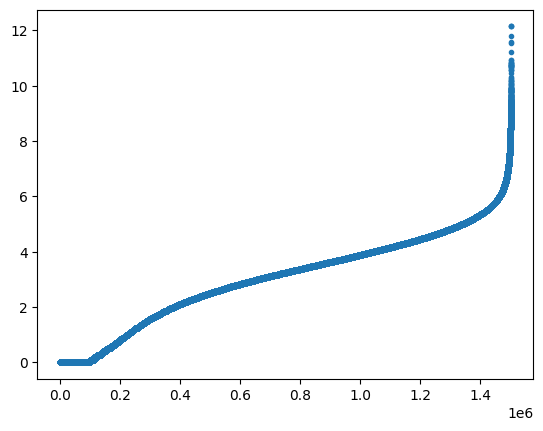

In [311]:
plt.plot(np.log1p(np.sort(df_final_long.Expression)), '.')

In [307]:
def calculate_enrichment_score(df, gene_set, group_col="Cell type class", expression_col="Expression"):
    """
    Calculates a specificty score for a gene set across different cell type classes.
    
    Args:
        df: The long-format dataframe.
        gene_set: A list/set of Gene_IDs to test.
        group_col: The column to group by (e.g., 'Cell type class').
        expression_col: The column containing expression values.
        
    Returns:
        A pandas Series with the enrichment score for each Cell type class.
    """
    
    # 1. PSEUDOBULK: Aggregate to get one value per gene per class
    # We use mean() to handle the "multiple tissues/clusters" issue
    pseudobulk = df.groupby([group_col, 'Gene_ID'])[expression_col].mean().unstack(level=0)
    
    # pseudobulk is now:
    # Rows = Genes
    # Cols = Cell type classes
    # Values = Mean Expression
    
    # 2. FILTER: subset to only genes present in your data
    # (Optional: Fill NaNs with 0 if a gene is completely missing in a class)
    pseudobulk = pseudobulk.fillna(0)
    
    # 3. Z-SCORE: Standardize each gene across the classes (Row-wise z-score)
    # This ensures that high-expression genes don't dominate the score
    # ddof=0 is population std dev, usually fine here.
    mean_gene = pseudobulk.mean(axis=1)
    std_gene = pseudobulk.std(axis=1)
    
    # Avoid division by zero for genes with constant expression
    std_gene = std_gene.replace(0, 1) 
    
    z_scored_expression = pseudobulk.sub(mean_gene, axis=0).div(std_gene, axis=0)
    
    # 4. SCORE: Calculate the Mean Z-score for the target gene set
    # Filter for genes actually in the dataframe
    valid_genes = [g for g in gene_set if g in z_scored_expression.index]
    
    if not valid_genes:
        return None
        
    # The final metric: Average Z-score of the gene set for each class
    enrichment_scores = z_scored_expression.loc[valid_genes].mean(axis=0)
    
    return enrichment_scores.sort_values(ascending=False)

In [310]:
# 1. Define your gene set (Use the exact IDs from your Gene_ID column)
my_gene_set = ['ENSG00000000419', 'ENSG00000284194', 'ENSG00000123456']
my_gene_set = adata_final[adata_final.obs.hdbscan==0].obs.target_contrast_corrected.unique().tolist()

# 2. Run the function
scores = calculate_enrichment_score(df_final_long, my_gene_set)

# 3. View results
print(scores)

# Interpretation:
# Positive Score: The gene set is expressed HIGHER in this class than the average across all classes.
# Negative Score: The gene set is DOWNREGULATED in this class relative to others.

Cell type class
Glial cells                     0.458481
Pigment cells                   0.333679
Blood and immune cells          0.321753
Neuronal cells                  0.315135
Endothelial and mural cells     0.294842
Trophoblast cells               0.138525
Mesenchymal cells               0.049700
Squamous epithelial cells       0.047733
Stem and proliferating cells   -0.003494
Ciliated cells                 -0.078702
Muscle cells                   -0.185080
Endocrine cells                -0.199267
Specialized epithelial cells   -0.342407
Glandular epithelial cells     -0.481936
Germ cells                     -0.668962
dtype: float64


/var/folders/qq/j023xkr13nxfrw65dx2bqwd00000gp/T/ipykernel_9081/774771038.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pseudobulk = df.groupby([group_col, 'Gene_ID'])[expression_col].mean().unstack(level=0)


In [473]:
def calculate_tau(matrix: pd.DataFrame) -> pd.Series:
    """Calculates the Tau specificity index for each gene (row)."""
    
    # Max Normalization: x_i / max(x)
    # Get the maximum expression across all tissues for each gene (row)
    max_vals = matrix.max(axis=1)
    
    # Handle the case where max_vals is 0 (i.e., gene is not expressed anywhere)
    max_vals[max_vals == 0] = 1e-9 
    
    # Normalized expression (x_hat)
    normalized = matrix.div(max_vals, axis=0)
    
    # Sum of (1 - x_hat)
    sum_term = (1 - normalized).sum(axis=1)
    
    # Divide by (N_tissues - 1)
    n_tissues = matrix.shape[1]
    tau_scores = sum_term / (n_tissues - 1)
    
    return tau_scores

In [474]:
def calculate_bem(matrix: pd.DataFrame, threshold: float) -> pd.Series:
    """
    Calculates the Broad Expression Metric (BEM): the percentage of tissues 
    where the expression is >= the threshold.
    """
    # Create a boolean matrix: True if detected (nTPM >= threshold)
    detected_matrix = matrix >= threshold
    
    # Count True values (detected tissues) per gene (row)
    tissue_count = detected_matrix.sum(axis=1)
    
    # Calculate BEM (%)
    total_tissues = matrix.shape[1]
    bem_scores = (tissue_count / total_tissues)
    
    return bem_scores

In [478]:
# Get gene id for all regulator genes
gene_id_in_clustering = adata_final.obs.target_contrast_corrected.unique().tolist()
gene_id_in_clustering = adata_final[adata_final.obs.hdbscan==27].obs.target_contrast_corrected.unique().tolist()
# Set tau threshold to 0.8
tau_thres = 0.8
NTPM_THRESHOLD = 10
bem_thres = 0.1

# Pivot the data to create the Expression Matrix (Genes x Tissues)
# Use the Ensembl ID (Gene) as the index for robustness
expression_matrix = df.pivot_table(
    index='Gene', 
    columns='Tissue', 
    values='nTPM'
)

# Filter the matrix to include only your genes
subset_matrix = expression_matrix.reindex(gene_id_in_clustering).dropna(how='all')

# Calculate the Tau scores
tau_scores = calculate_tau(subset_matrix)
# Calculate BEM scores
bem_scores = calculate_bem(subset_matrix, NTPM_THRESHOLD)

# Determine the tissue with the highest expression for each gene
max_tissue = subset_matrix.idxmax(axis=1)

# List of immune/lymphoid tissues for classification (based on previous discussion)
IMMUNE_TISSUES = [
    'thymus', 'lymph node', 'spleen', 'bone marrow', 'tonsil', 'appendix', 
]

# Create the final results DataFrame
results = pd.DataFrame({
    'Tau_Score': tau_scores,
    'BEM_Score': bem_scores,
    'Max_Expression_Tissue': max_tissue,
    'Is_Tissue_Specific': bem_scores <= bem_thres,
})

# Classify as Immune-Specific
results['Is_Immune_Specific'] = results.apply(
    lambda row: row['Is_Tissue_Specific'] and (row['Max_Expression_Tissue'] in IMMUNE_TISSUES), 
    axis=1
)

gene_name_map = adata_final.obs[['target_contrast_corrected', 'target_contrast_gene_name_corrected']].drop_duplicates().set_index('target_contrast_corrected')
results = results.join(gene_name_map)

In [480]:
print(results['target_contrast_gene_name_corrected'].tolist())

['PIGF', 'NPAS2', 'ZNF221', 'ST7L', 'ZSWIM4', 'COX5B', 'IL9', 'LRP6', 'SLC35C2', 'GOLGA3', 'NFAT5', 'TRRAP', 'TMEM30A', 'DENND2D', 'RASA4B', 'SEC24A', 'ARNT', 'AHR', 'ZCCHC4', 'LPCAT3', 'FAM89B', 'RGPD6', 'NUDT19', 'RNF115', 'PRSS21', 'ATP2B1', 'CFAP97', 'KRBA2', 'DYNLT2B', 'CBFA2T2', 'GGA3', 'GNA13', 'PTGER3', 'TNS1', 'CAV1', 'NKX2-8', 'ZNF518A', 'C6orf62', 'PIGH', 'PTCH1', 'MCAT', 'PRRT2', 'RXRB', 'PPIF', 'RBM10', 'SLC35D2', 'ARHGAP30', 'PRXL2B', 'ZNF662', 'HOXC10', 'CCR10', 'NMT1', 'SLC25A3', 'RHOC', 'BARX1', 'MVB12B', 'TP53', 'SLC27A3', 'TAOK2', 'EIF4G2', 'APOBEC3G', 'SEC14L2', 'TPD52L1', 'PPP1R12C', 'ETNK1', 'SP100', 'C1orf21', 'BRD10', 'FBXL15', 'STARD10', 'IMPG2', 'PTRH2', 'ZBTB9', 'HYKK', 'FBF1', 'ZNF304', 'SUPT3H', 'DNAJC4', 'ZNF512B', 'DLG4', 'CKAP4', 'SBF1', 'ZNF653', 'BLZF1', 'HIP1R', 'RASAL3', 'SRSF11', 'ZHX1-C8orf76', 'TRUB1', 'SEMA4C', 'AKR1C1', 'ABHD12', 'ATP5F1B', 'EI24', 'ZNF18', 'TMED4', 'AIP', 'EFHC1', 'NRBP1', 'GABARAPL1', 'CD2BP2', 'DVL1', 'CCR4', 'TMEM87B', 'CEP4

In [481]:
results.sort_values(by='target_contrast_gene_name_corrected')

,Tau_Score,BEM_Score,Max_Expression_Tissue,Is_Tissue_Specific,Is_Immune_Specific,target_contrast_gene_name_corrected
Gene,,,,,,
ENSG00000100997,0.664026,1.000000,epididymis,False,False,ABHD12
ENSG00000164398,0.884434,0.235294,retina,False,False,ACSL6
ENSG00000154930,0.828214,0.960784,choroid plexus,False,False,ACSS1
ENSG00000129467,0.780648,0.196078,adipose tissue,False,False,ADCY4
ENSG00000204310,0.544279,0.882353,cerebral cortex,False,False,AGPAT1
ENSG00000106546,0.735119,0.529412,urinary bladder,False,False,AHR
ENSG00000110711,0.473144,1.000000,blood vessel,False,False,AIP
ENSG00000187134,0.944689,0.666667,liver,False,False,AKR1C1
ENSG00000184675,0.889790,0.019608,tongue,True,False,AMER1


In [73]:
results[results.target_contrast_gene_name_corrected.isin(['PTPRC', 'VAV1', 'AHR', 'IL2RB', 'NCKAP1L', 'DOCK2',
                                                          'ARHGAP30','WASF2','LRP6','GNA13','ARNT','EHMT1','EHMT2',
                                                         'SLC25A1','PDHA1','PDHB','MDH2','DLAT','CS','ACLY','STYXL1'])]

,Tau_Score,BEM_Score,Max_Expression_Tissue,Is_Tissue_Specific,Is_Immune_Specific,target_contrast_gene_name_corrected
Gene,,,,,,
ENSG00000070018,0.629231,0.000000,placenta,True,False,LRP6
ENSG00000106546,0.735119,0.529412,urinary bladder,False,False,AHR
ENSG00000143437,0.522145,0.862745,liver,False,False,ARNT
ENSG00000204371,0.704745,0.372549,basal ganglia,False,False,EHMT2
ENSG00000100385,0.891078,0.156863,spleen,False,False,IL2RB
ENSG00000127952,0.683180,0.823529,choroid plexus,False,False,STYXL1
ENSG00000120063,0.851965,0.921569,bone marrow,False,False,GNA13
ENSG00000100075,0.794683,0.960784,liver,False,False,SLC25A1
ENSG00000081237,0.893776,0.431373,lymph node,False,False,PTPRC


In [78]:
print(adata_final[adata_final.obs.hdbscan==27].obs.target_contrast_gene_name_corrected.tolist())

['PIGF', 'NPAS2', 'ZNF221', 'ST7L', 'ZSWIM4', 'COX5B', 'IL9', 'LRP6', 'SLC35C2', 'GOLGA3', 'NFAT5', 'TRRAP', 'TMEM30A', 'DENND2D', 'RASA4B', 'SEC24A', 'ARNT', 'AHR', 'ZCCHC4', 'LPCAT3', 'FAM89B', 'RGPD6', 'NUDT19', 'RNF115', 'PRSS21', 'ATP2B1', 'CFAP97', 'KRBA2', 'DYNLT2B', 'CBFA2T2', 'GGA3', 'GNA13', 'PTGER3', 'TNS1', 'CAV1', 'NKX2-8', 'ZNF518A', 'C6orf62', 'PIGH', 'PTCH1', 'MCAT', 'PRRT2', 'RXRB', 'PPIF', 'RBM10', 'SLC35D2', 'ARHGAP30', 'PRXL2B', 'ZNF662', 'HOXC10', 'CCR10', 'NMT1', 'SLC25A3', 'RHOC', 'BARX1', 'MVB12B', 'TP53', 'SLC27A3', 'TAOK2', 'EIF4G2', 'APOBEC3G', 'SEC14L2', 'TPD52L1', 'PPP1R12C', 'ETNK1', 'SP100', 'C1orf21', 'BRD10', 'FBXL15', 'STARD10', 'IMPG2', 'PTRH2', 'ZBTB9', 'HYKK', 'FBF1', 'ZNF304', 'SUPT3H', 'DNAJC4', 'ZNF512B', 'DLG4', 'CKAP4', 'SBF1', 'ZNF653', 'BLZF1', 'HIP1R', 'RASAL3', 'SRSF11', 'ZHX1-C8orf76', 'TRUB1', 'SEMA4C', 'AKR1C1', 'ABHD12', 'ATP5F1B', 'EI24', 'ZNF18', 'TMED4', 'AIP', 'EFHC1', 'NRBP1', 'GABARAPL1', 'CD2BP2', 'DVL1', 'CCR4', 'TMEM87B', 'CEP4

In [87]:
df[df['Gene name']=='NFAT5']

,Gene,Gene name,Tissue,nTPM
137741,ENSG00000102908,NFAT5,adipose tissue,2.0
137742,ENSG00000102908,NFAT5,adrenal gland,2.9
137743,ENSG00000102908,NFAT5,amygdala,0.6
137744,ENSG00000102908,NFAT5,appendix,2.7
137745,ENSG00000102908,NFAT5,basal ganglia,0.7
137746,ENSG00000102908,NFAT5,blood vessel,2.5
137747,ENSG00000102908,NFAT5,bone marrow,5.3
137748,ENSG00000102908,NFAT5,breast,1.8
137749,ENSG00000102908,NFAT5,cerebellum,2.2
137750,ENSG00000102908,NFAT5,cerebral cortex,2.8


In [42]:
df[df.Gene=='ENSG00000168291']

,Gene,Gene name,Tissue,nTPM
616836,ENSG00000168291,PDHB,adipose tissue,56.2
616837,ENSG00000168291,PDHB,adrenal gland,73.4
616838,ENSG00000168291,PDHB,amygdala,50.1
616839,ENSG00000168291,PDHB,appendix,39.9
616840,ENSG00000168291,PDHB,basal ganglia,56.7
616841,ENSG00000168291,PDHB,blood vessel,58.2
616842,ENSG00000168291,PDHB,bone marrow,24.4
616843,ENSG00000168291,PDHB,breast,40.5
616844,ENSG00000168291,PDHB,cerebellum,32.1
616845,ENSG00000168291,PDHB,cerebral cortex,58.5


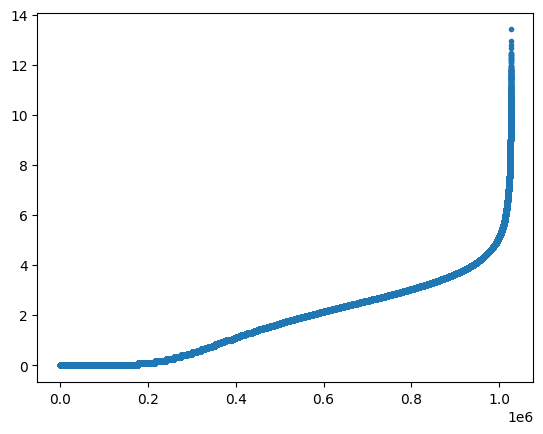

In [61]:
plt.plot(np.log1p(np.sort(df.nTPM)), '.')

In [63]:
np.exp(1)-1

1.718281828459045

In [22]:
gene_name_map[gene_name_map.target_contrast_gene_name_corrected=='IL2RA']

,target_contrast_gene_name_corrected
target_contrast_corrected,
